In [4]:
#Import the libraries

import pandas as pd
import numpy as np

In [20]:
#step 1: Import the data
df = pd.read_excel('data_base_prediction.xlsx', parse_dates=['Invoice Date'])


In [12]:
df.head()

,Invoice Date,Item Code,QTY
0,2024-12-31,155108e1,1
1,2024-12-31,7fdf96c6,1
2,2024-12-31,4c201ddc,3
3,2024-12-31,c23dc657,1
4,2024-12-31,dc08c95c,8


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974970 entries, 0 to 974969
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Invoice Date  974970 non-null  datetime64[ns]
 1   Item Code     974970 non-null  object        
 2   QTY           974970 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 22.3+ MB


In [22]:
#step 2: creatinf the month colum inreference to the Invoice data, here all the date stamps in a month \n
# will have one datestamp value in month colum and that will be first of that perticular month

df['month'] = df['Invoice Date'].dt.to_period('M').dt.to_timestamp()

In [24]:
df.head()

,Invoice Date,Item Code,QTY,month
0,2024-12-31,155108e1,1,2024-12-01
1,2024-12-31,7fdf96c6,1,2024-12-01
2,2024-12-31,4c201ddc,3,2024-12-01
3,2024-12-31,c23dc657,1,2024-12-01
4,2024-12-31,dc08c95c,8,2024-12-01


In [29]:
# Step 3: Aggregate monthly consumption per SKU
monthly_df = (df.groupby(['Item Code','month'])['QTY'].sum().reset_index())



In [31]:
monthly_df.head()

,Item Code,month,QTY
0,001343f3,2024-01-01,155
1,001343f3,2024-02-01,120
2,001343f3,2024-03-01,211
3,001343f3,2024-04-01,10
4,001343f3,2024-05-01,20


In [33]:
# Step 4: Compute z-scores by item
def compute_z_score(group):
    group = group.sort_values('month')
    recent_month = group['month'].max()
    historical = group[group['month'] < recent_month]
    recent = group[group['month'] == recent_month]

    if historical.shape[0] < 4:
        return pd.DataFrame({
            'Item Code': [group['Item Code'].iloc[0]],
            #'Item Name': [group['Item Name'].iloc[0]],
            'z_score': [np.nan],
            'status': ['Insufficient history']
        })
    
    mean = historical['QTY'].mean()
    std = historical['QTY'].std()
    recent_qty = recent['QTY'].values[0]
    
    if std == 0:
        z = 0
    else:
        z = (recent_qty - mean) / std

    # Determine status
    if z > 2:
        status = "Unexpected spike"
    elif z > 1.5:
        status = "Monitor the consumption"
    #elif z<0 and z>-2:
      #  status= "Reduction in consumption"
    elif z< -2:
        status= "Unexpected Consumption Reduced" 
    else:
        status = "Within expected range"

    return pd.DataFrame({
        'Item Code': [group['Item Code'].iloc[0]],
        #'Item Name': [group['Item Name'].iloc[0]],
        'z_score': [round(z, 2)],
        'status': [status]
    })


In [37]:
# Step 5: Apply z-score logic per item to entire data frame
result_df = (monthly_df.groupby(['Item Code']).apply(compute_z_score).reset_index(drop=True))

/var/folders/v6/b6p52t217dl0zncsqc790k4m0000gn/T/ipykernel_83871/665484434.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = (monthly_df.groupby(['Item Code']).apply(compute_z_score).reset_index(drop=True))


In [39]:
result_df.head()

,Item Code,z_score,status
0,001343f3,0.25,Within expected range
1,00225dd5,NaN,Insufficient history
2,002c3dfa,NaN,Insufficient history
3,00360ad5,-1.52,Within expected range
4,004ae629,NaN,Insufficient history


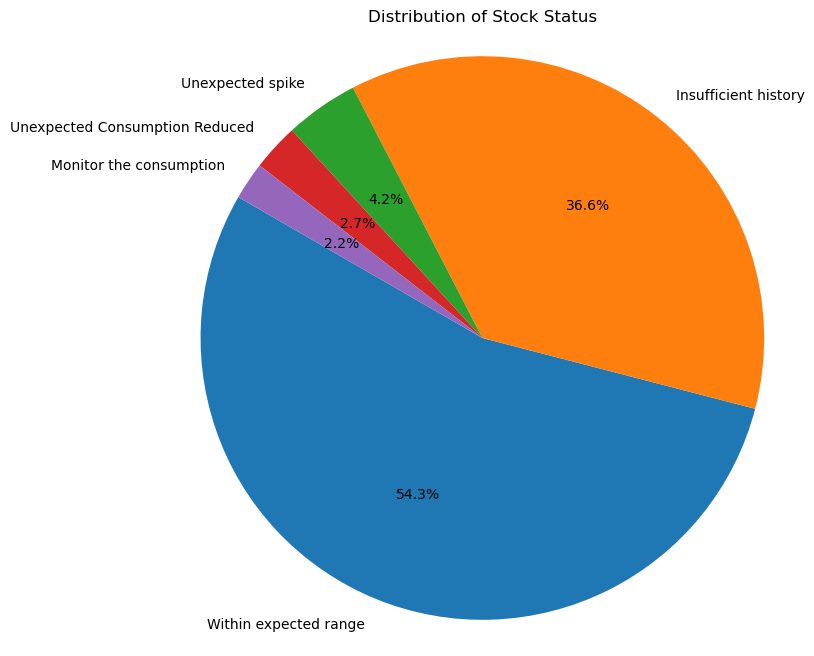

In [45]:
#step 6: Visualization of the stock distribution

import matplotlib.pyplot as plt

# Count the frequency of each unique status
status_counts = result_df['status'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: size of the figure
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=150)

# Add a title
plt.title('Distribution of Stock Status')

# Make it a circle (equal aspect ratio)
plt.axis('equal')

# Show the plot
plt.show()

In [43]:
result_df.to_excel('prediction_results_final.xlsx')